# Load Amazon Data

In [1]:
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


In [23]:
df_meta = getDF('data/electronics/meta_Electronics.json.gz')
df_reviews = getDF('data/electronics/reviews_Electronics.json.gz')

# Clean Data

In [24]:
# Drop indices where price = Null
print('Number of Products: ', df_meta.shape[0])
print('Number of Null Prices: ', df_meta.price.isnull().sum())
df_meta = df_meta[~df_meta.price.isnull()]

Number of Products:  498196
Number of Null Prices:  108503


In [25]:
df_reviews.shape

(7824482, 9)

In [26]:
# There are no NA values in ratings but some products don't have reviews.
# Did inner join on the two dataframes using product id
final_df = df_meta.merge(df_reviews, how='inner', on='asin')

In [27]:
final_df.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN,A2NWSAGRHCP8N5,bowmans2007,"[1, 1]",It never worked. My daughter worked to earn th...,1.0,absolutely horrible,1367193600,"04 29, 2013"
1,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN,A2WNBOD3WNDNKT,JAL,"[1, 1]",Some of the functions did not work properly. ...,3.0,Disappointing,1374451200,"07 22, 2013"
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN,A1GI0U4ZRJA8WN,Truthfull,"[4, 4]",Do not waste your money on this thing it is te...,1.0,TERRIBLE DONT WASTE YOUR MONEY,1334707200,"04 18, 2012"
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN,A1QGNMC6O1VW39,CK,"[0, 0]",Dog got the old remote and destroyed it. Didn...,5.0,Works Great with my TWC box,1397433600,"04 14, 2014"
4,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN,A3J3BRHTDRFJ2G,"EJ Honda ""ejhonda""","[1, 1]","This remote, for whatever reason, was chosen b...",2.0,Ergonomic nightmare,1397433600,"04 14, 2014"


In [28]:
n_ratings = np.arange(1, 100)
n_products = []
for n in n_ratings:
    n_products.append(np.sum(final_df.groupby(by='asin').overall.count() > n))

# Visualize Data

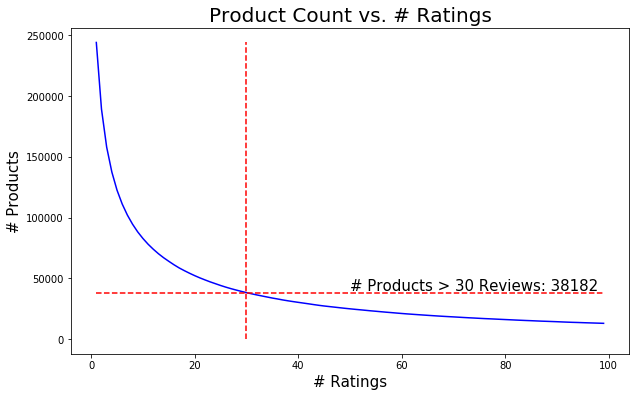

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_ratings, n_products, 'b')
ax.plot(n_ratings, [n_products[29]]*len(n_ratings),'r--')
ax.plot([30]*len(n_ratings), np.linspace(0,max(n_products),len(n_ratings)),'r--')
plt.text(50,40000, '# Products > 30 Reviews: {}'.format(
    np.sum(final_df.groupby(by='asin').overall.count() > 30)),fontsize=15)
ax.set_xlabel('# Ratings', fontsize=15)
ax.set_ylabel('# Products', fontsize=15)
ax.set_title('Product Count vs. # Ratings', fontsize=20)
plt.savefig('prod_count_vs_rating.png')

In [30]:
indices = final_df.groupby(by='asin').overall.count() > 30
temp_df = final_df.groupby(by='asin').mean()

In [31]:
ff_df = temp_df.iloc[indices.values, :]

Text(0.5,1,'Product Rating vs. Price')

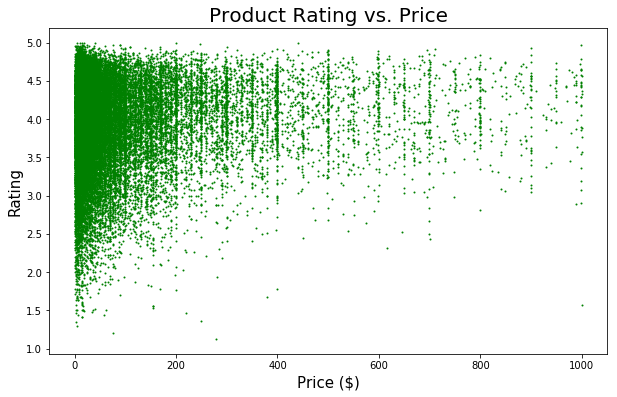

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(ff_df.price, ff_df.overall, c='g', s=1)
ax.set_xlabel('Price ($)', fontsize=15)
ax.set_ylabel('Rating', fontsize=15)
ax.set_title('Product Rating vs. Price', fontsize=20)

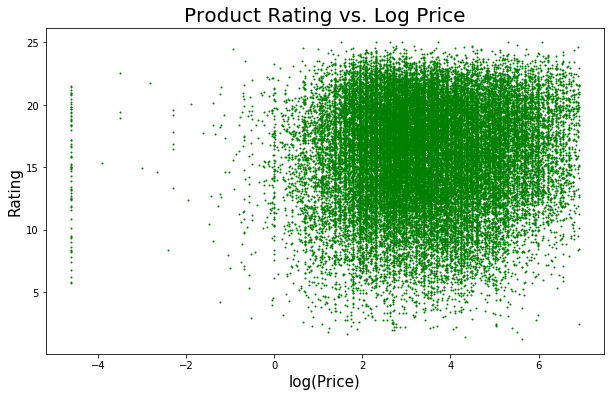

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(np.log(ff_df.price), ff_df.overall**2, c='g', s=1)
ax.set_xlabel('log(Price)', fontsize=15)
ax.set_ylabel('Rating', fontsize=15)
ax.set_title('Product Rating vs. Log Price', fontsize=20)
plt.savefig('prod_rating_vs_logprice.png')

In [34]:
X_data = np.log(ff_df.price).values.reshape(-1,1)
y_data = ff_df.overall**2
lm = LinearRegression().fit(X_data, y_data)
y_pred = lm.predict(X_data)

Text(0.5,1,'Product Rating vs. Log Price')

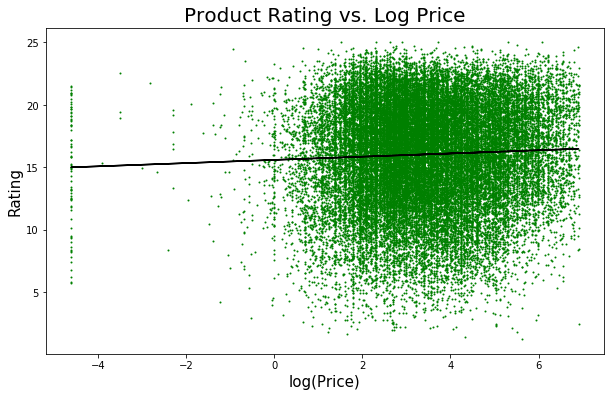

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(np.log(ff_df.price), ff_df.overall**2, c='g', s=1)
ax.plot(np.log(ff_df.price), y_pred, 'k-')
ax.set_xlabel('log(Price)', fontsize=15)
ax.set_ylabel('Rating', fontsize=15)
ax.set_title('Product Rating vs. Log Price', fontsize=20)


In [36]:
from sklearn.metrics import r2_score
r2_score(ff_df.overall, y_pred)

-485.9428602790452

Text(0.5,1,'Rating Distribution')

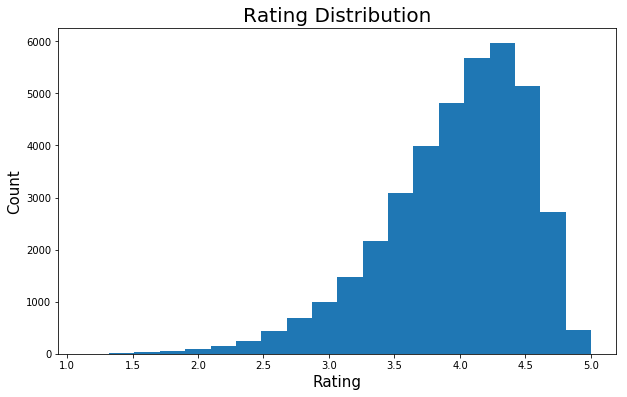

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(ff_df.overall, 20)
ax.set_xlabel('Rating', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Rating Distribution', fontsize=20)

In [38]:
ref_list = list(ff_df.index)
print('Number of Products w/ > 30 Reviews: ', len(ref_list))

Number of Products w/ > 30 Reviews:  38182


# Final Cleaning + Save Data

In [39]:
# Clearing out Null Titles
print('Number of Null Titles: ', np.sum(final_df['title'].isnull())/len(final_df['title'].isnull()))
final_df = final_df[final_df.asin.isin(ref_list)]
inds = np.asarray(final_df['title'].isnull()).nonzero()
final_df = final_df.dropna(subset=['title'])

Number of Null Titles:  0.03800779541755676


In [40]:
final_df.groupby(by='brand').count()

,asin,imUrl,description,categories,title,price,salesRank,related,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
brand,,,,,,,,,,,,,,,,
,8485,8485,8322,8485,8485,8485,4188,8485,8485,8313,8485,8485,8485,8485,8485,8485
(CHARGER4U),38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
1800Battery,175,175,175,175,175,175,175,175,175,173,175,175,175,175,175,175
180s,43,43,0,43,43,43,43,43,43,43,43,43,43,43,43,43
1D,120,120,120,120,120,120,0,120,120,120,120,120,120,120,120,120
2791 2795,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
2K,357,357,357,357,357,357,322,357,357,357,357,357,357,357,357,357
2Wire,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107,107
32sports.com,31,31,31,31,31,31,0,31,31,31,31,31,31,31,31,31


In [41]:
final_df.to_csv('data/electronics_cleaned.csv')

In [42]:
ff_df.to_csv('data/electronics_grouped.csv')